**5. Computing % of progressive passes made in each region by an LCB based on dominant foot**

A pass said to be progressive if:

    a. x_component (final pass lcocation) - x_component (initial pass location) >= 30 if the pass is initiated behind the half line
    
    b. x_component (final pass lcocation) - x_component (initial pass location) >= 10 if the pass is initiated ahead of the half line
    
This notebook gives an idea as to how different footed LCBs access different parts of the field differently during a progressive build up

The following tasks have been taken into account in this notebook:

1. Segregate accurate progressive passes from accurate passes and plot the initial and the final pass locations of these passes

2. Find % of accurate passes made by LCB in

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('max_columns',100)

In [32]:
# Paths for cluster files for 4 defender formations
base_path = "../data/clusters/clusters_v3"
clusters = ['rll','rlll','rlr','rrl','rrll','rrlll','rrlr','rrr','rrrl','rrrll','rrrlr','rrrr','rrrrl']
files = [os.path.join(base_path,'cluster_' + cluster + '.pkl') for cluster in clusters]

In [4]:
# Reading cluster files
df_clusters = list()
for file in files:
    df_clusters.append(pd.read_pickle(file))

In [5]:
# Reseting index of clusters
for df in df_clusters:
    df.reset_index(inplace = True)

In [6]:
# Function to get start and end location points for every row in df
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

In [7]:
# Function to apply progressive pass filter
def distfilter(locs):
    loc_start, loc_end = getstartend(locs)
    prog_accpasslocs = list()
    for p1,p2 in zip(loc_start,loc_end):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_accpasslocs.append([p1,p2])
        elif p1[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_accpasslocs.append([p1,p2])
    return prog_accpasslocs
            

In [8]:
# Creating progressive pass column for LCB in a four defender formation
df_clusters_prog = list()
for df in df_clusters:
    if df['backline'][0] == 4:
        df['L_CB_progaccpassloc'] = df.apply(lambda x: distfilter(x['L_CB_accpassloc']),axis = 1)
    elif df['backline'][0] in [3,5]:
        df['LCB_progaccpassloc'] = df.apply(lambda x: distfilter(x['LCB_accpassloc']), axis = 1)
    df_clusters_prog.append(df)

In [9]:
# Function to get start and end location points for a whole df column
def getstartendfull(locs):
    end_points = list()
    start_points = list()
    for match in locs:
        for point in match:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

In [10]:
# Counting number of progressive passes
counter = 0
for df in df_clusters_prog:
    if df['backline'][0] in [3,5]:
        start,end = getstartendfull(df['LCB_progaccpassloc'])
        counter = counter + len(start)
    elif df['backline'][0] == 4:
        start,end = getstartendfull(df['L_CB_progaccpassloc'])
        counter = counter + len(start)
counter

6864

In [11]:
# Counting number of accurate passes
counter_acc = 0
for df in df_clusters_prog:
    if df['backline'][0] in [3,5]:
        start,end = getstartendfull(df['LCB_accpassloc'])
        counter_acc = counter_acc + len(start)
    elif df['backline'][0] == 4:
        start,end = getstartendfull(df['L_CB_accpassloc'])
        counter_acc = counter_acc + len(start)
counter_acc

30220

In [12]:
# Saving the updated clusters as pickle files
clusters = ['rll','rlll','rlr','rrl','rrll','rrlll','rrlr','rrr','rrrl','rrrll','rrrlr','rrrr','rrrrl']
for i, df in enumerate(df_clusters_prog):
    df.to_pickle(f'../data/clusters/clusters_prog/cluster_prog_{clusters[i]}.pkl')

**Plotting the progressive passes**

In [13]:
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [14]:
def draw_pitch(line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
        circle4 = plt.Circle((93, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle5 = plt.Circle((11, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle6 = plt.Circle((52, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-', color="None", zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-', color='None', zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color="None", zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
        
    return fig, ax

In [15]:
def heatmap(x, y, title, c):
    fig, ax = draw_pitch("#000000","h","full")
    sns.kdeplot(x, y, cmap = c, shade = True)
    plt.title(title, fontsize = 30)
    plt.xlim(-1,105)
    plt.ylim(-1,69)
    plt.axis('off')
    plt.show()

**Plotting progressive passes for 4 defender formations**

In [69]:
df_rrrl = pd.read_pickle('../data/clusters/clusters_prog/cluster_prog_rrrl.pkl')

In [70]:
rrrlprogloclist = df_rrrl['L_CB_progaccpassloc'].tolist()

In [71]:
rrrl_prog_start, rrrl_prog_end = getstartendfull(rrrlprogloclist)

In [72]:
rrrl_prog_start_x, rrrl_prog_start_y = getxy(rrrl_prog_start)

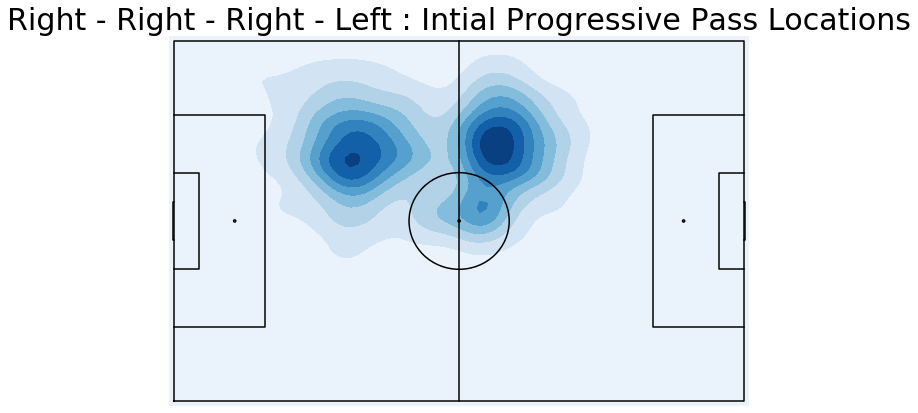

In [73]:
heatmap(rrrl_prog_start_x, rrrl_prog_start_y, 'Right - Right - Right - Left : Intial Progressive Pass Locations', 'Blues')

In [74]:
rrrl_prog_end_x, rrrl_prog_end_y = getxy(rrrl_prog_end)
print(len(rrrl_prog_end_x))

2777


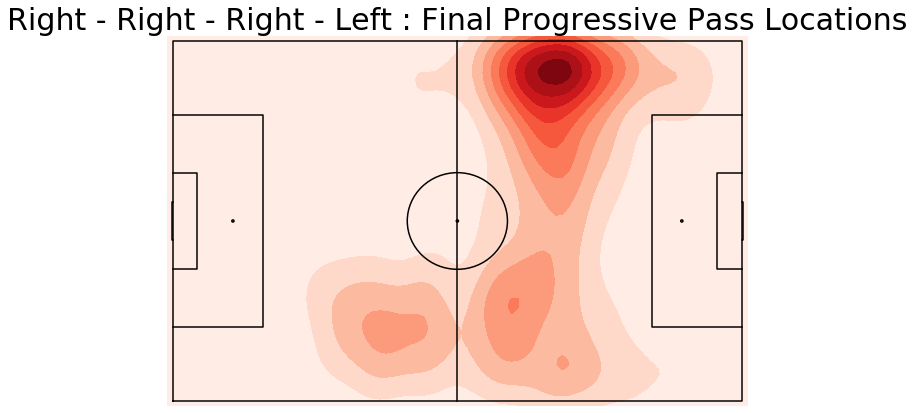

In [75]:
heatmap(rrrl_prog_end_x, rrrl_prog_end_y, 'Right - Right - Right - Left : Final Progressive Pass Locations', 'Reds')

In [76]:
df_rrll = pd.read_pickle('../data/clusters/clusters_prog/cluster_prog_rrll.pkl')

In [77]:
rrllprogloclist = df_rrll['L_CB_progaccpassloc'].tolist()

In [78]:
rrll_prog_start, rrll_prog_end = getstartendfull(rrllprogloclist)

In [79]:
rrll_prog_start_x, rrll_prog_start_y = getxy(rrll_prog_start)
print(len(rrll_prog_start_x))

1587


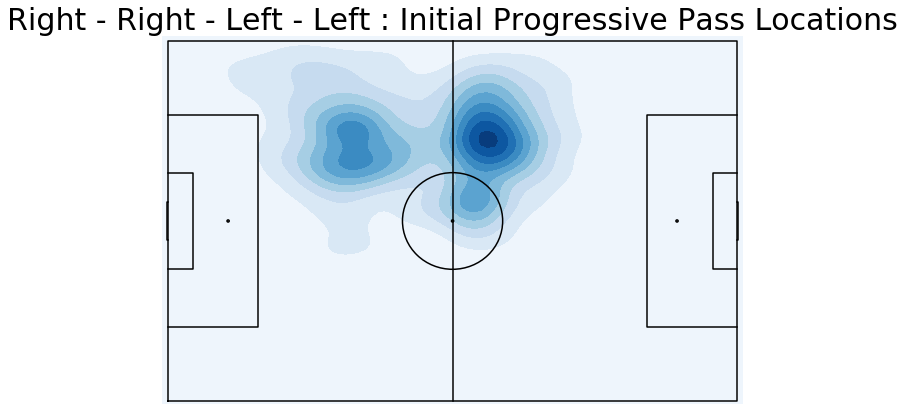

In [80]:
heatmap(rrll_prog_start_x, rrll_prog_start_y, 'Right - Right - Left - Left : Initial Progressive Pass Locations', 'Blues')

In [81]:
rrll_prog_end_x, rrll_prog_end_y = getxy(rrll_prog_end)

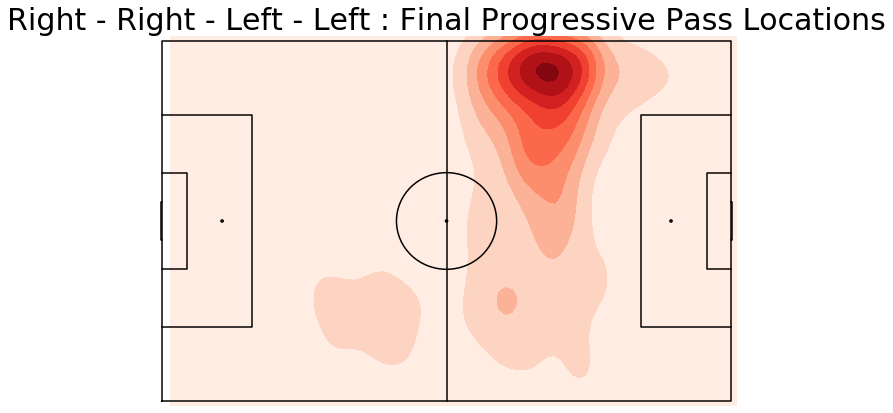

In [82]:
heatmap(rrll_prog_end_x, rrll_prog_end_y, 'Right - Right - Left - Left : Final Progressive Pass Locations', 'Reds')

**Plotting progressive passes for 3 or 5 defender formation**

In [83]:
# Creating dataframes for clusters for 3 or 5 defender formations
three_five_clusters = ['rrl','rrr','rll','rrrll','rrrrl','rlr','rrrlr','rrlll']
lcb_lf_clusters = ['rrl','rll','rrrll','rrrlr','rrlll']
lcb_rf_clusters = ['rrr','rrrrl','rlr']
path = '../data/clusters/clusters_prog'
lcb_lf_files = [os.path.join(path,f"cluster_prog_{name}.pkl") for name in lcb_lf_clusters]
lcb_rf_files = [os.path.join(path,f"cluster_prog_{name}.pkl") for name in lcb_rf_clusters]
lcb_lf = pd.concat((pd.read_pickle(file) for file in lcb_lf_files), axis = 0, ignore_index = True)
lcb_rf = pd.concat((pd.read_pickle(file) for file in lcb_rf_files), axis = 0, ignore_index = True)

In [84]:
lcb_lf_progpassloclist = lcb_lf['LCB_progaccpassloc'].tolist()
lcb_rf_progpassloclist = lcb_rf['LCB_progaccpassloc'].tolist()

In [85]:
lcb_lf_prog_start, lcb_lf_prog_end = getstartendfull(lcb_lf_progpassloclist)
lcb_rf_prog_start, lcb_rf_prog_end = getstartendfull(lcb_rf_progpassloclist)

In [86]:
lcb_lf_prog_start_x, lcb_lf_prog_start_y = getxy(lcb_lf_prog_start)
lcb_lf_prog_end_x, lcb_lf_prog_end_y = getxy(lcb_lf_prog_end)
lcb_rf_prog_start_x, lcb_rf_prog_start_y = getxy(lcb_rf_prog_start)
lcb_rf_prog_end_x, lcb_rf_prog_end_y = getxy(lcb_rf_prog_end)
print(len(lcb_lf_prog_start_x))
print(len(lcb_rf_prog_start_x))

1045
894


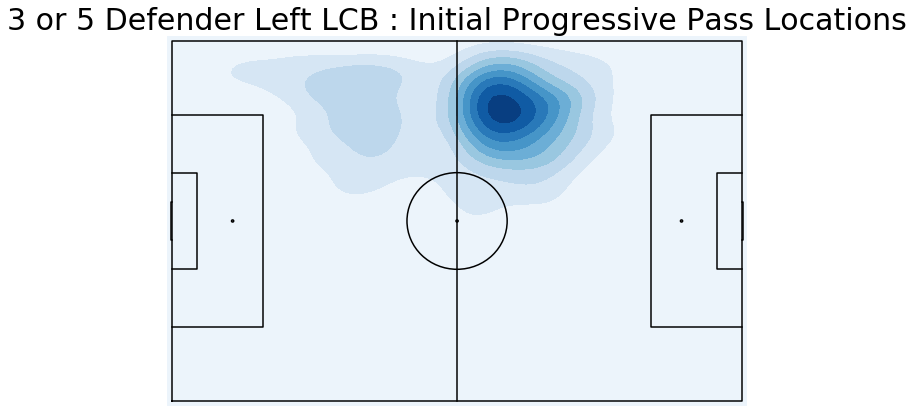

In [87]:
heatmap(lcb_lf_prog_start_x, lcb_lf_prog_start_y, '3 or 5 Defender Left LCB : Initial Progressive Pass Locations', 'Blues')

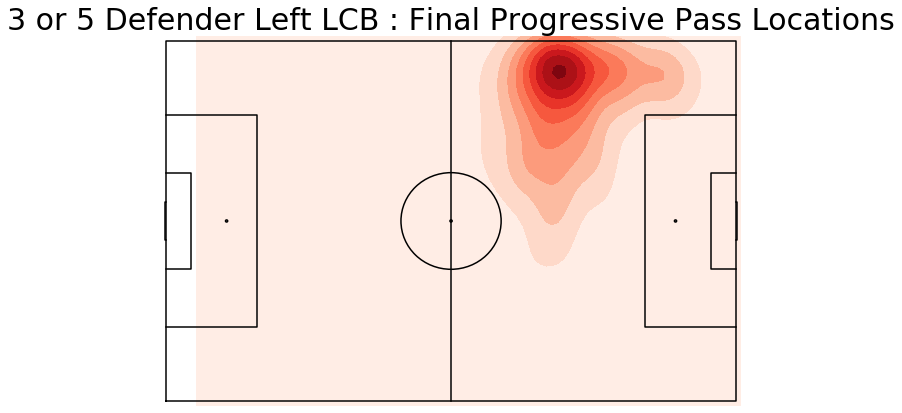

In [88]:
heatmap(lcb_lf_prog_end_x, lcb_lf_prog_end_y, '3 or 5 Defender Left LCB : Final Progressive Pass Locations', 'Reds')

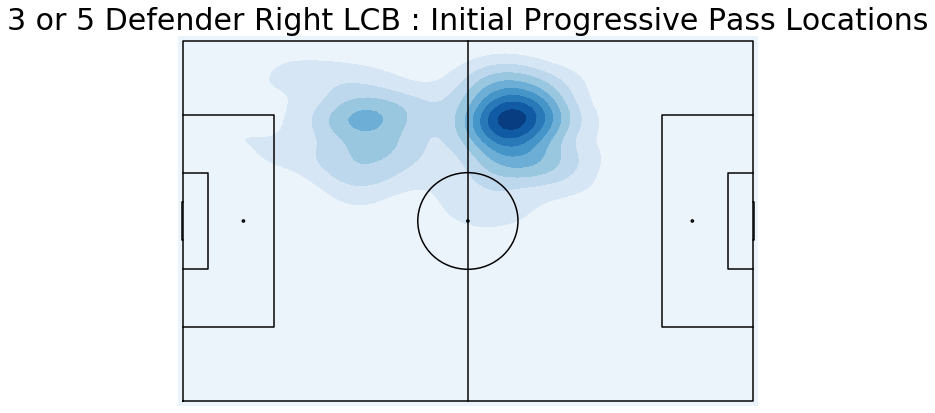

In [89]:
heatmap(lcb_rf_prog_start_x, lcb_rf_prog_start_y, '3 or 5 Defender Right LCB : Initial Progressive Pass Locations', 'Blues')

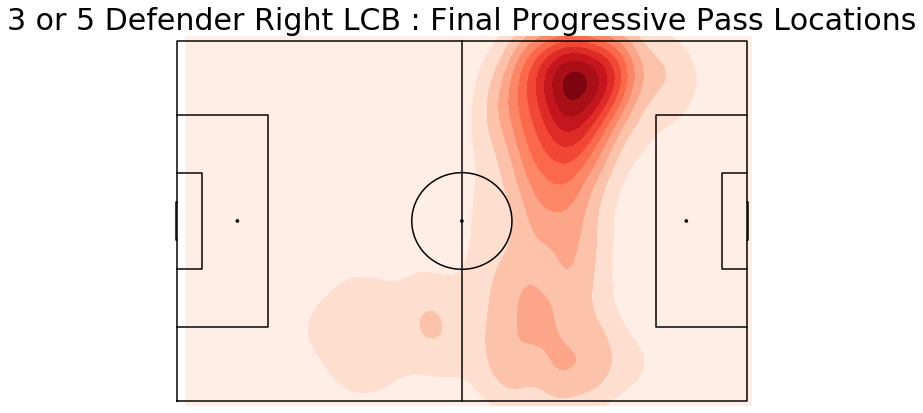

In [90]:
heatmap(lcb_rf_prog_end_x, lcb_rf_prog_end_y, '3 or 5 Defender Right LCB : Final Progressive Pass Locations', 'Reds')

**Finding percentage of progressive passes per region for LCBs in four defender formations (RRRL and RRLL)**

Order:<br>percentage(x_rightflank_attack), percentage(x_rightflank_def), percentage(
        x_leftflank_attack), percentage(x_leftflank_def), percentage(
            x_rightcentral_attack), percentage(x_rightcentral_def), percentage(
                x_leftcentral_attack), percentage(x_leftcentral_def)

In [91]:
def get_region(x, y):

    x_rightflank_attack = [
        x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
    ]
    y_rightflank_attack = [
        y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
    ]
    x_rightflank_def = [
        x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
    ]
    y_rightflank_def = [
        y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
    ]

    x_leftflank_attack = [
        x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
    ]
    y_leftflank_attack = [
        y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
    ]
    x_leftflank_def = [
        x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
    ]
    y_leftflank_def = [
        y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
    ]

    x_rightcentral_attack = [
        x[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    y_rightcentral_attack = [
        y[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    x_rightcentral_def = [
        x[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    y_rightcentral_def = [
        y[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
    ]

    x_leftcentral_attack = [
        x[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    y_leftcentral_attack = [
        y[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    x_leftcentral_def = [
        x[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    y_leftcentral_def = [
        y[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
    ]

    return [len(x_rightflank_attack), len(x_rightflank_def), len(
        x_leftflank_attack), len(x_leftflank_def), len(
            x_rightcentral_attack), len(x_rightcentral_def), len(
                x_leftcentral_attack), len(x_leftcentral_def)]

In [92]:
rrrl_region = get_region(rrrl_prog_end_x, rrrl_prog_end_y)
print(rrrl_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
rrrl_region_per = [i/len(rrrl_prog_end_x)*100 for i in rrrl_region]
for region, percent in zip(regions,rrrl_region_per):
    print(region,":",percent)

[454, 302, 1035, 96, 338, 172, 367, 13]
rightflank_attack : 16.348577601728483
rightflank_def : 10.875045012603529
leftflank_attack : 37.27043572200216
leftflank_def : 3.456967951026287
rightcentral_attack : 12.171407994238386
rightcentral_def : 6.1937342455887645
leftcentral_attack : 13.215700396110911
leftcentral_def : 0.4681310767014764


In [93]:
rrll_region = get_region(rrll_prog_end_x, rrll_prog_end_y)
print(rrll_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
rrll_region_per = [i/len(rrll_prog_end_x)*100 for i in rrll_region]
for region, percent in zip(regions,rrll_region_per):
    print(region,":",percent)

[168, 100, 687, 46, 205, 82, 286, 13]
rightflank_attack : 10.58601134215501
rightflank_def : 6.301197227473219
leftflank_attack : 43.28922495274102
leftflank_def : 2.898550724637681
rightcentral_attack : 12.917454316320102
rightcentral_def : 5.16698172652804
leftcentral_attack : 18.021424070573406
leftcentral_def : 0.8191556395715185


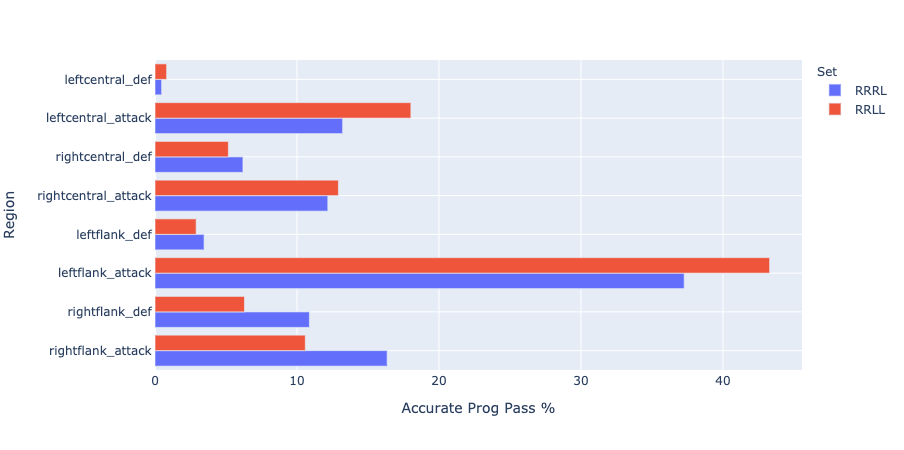

In [117]:
# data_reg = [['Right Flank Attack', 16.348577601728483, 'RRRL'],
#             ['Right Flank Attack',10.58601134215501, 'RRLL'],
#             ['Right Flank Def', 10.875045012603529, 'RRRL'],
#             ['Right Flank Def', 6.301197227473219, 'RRLL'],
#             ['Left Flank Attack', 37.27043572200216, 'RRRL'],
#             ['Left Flank Attack', 43.28922495274102, 'RRLL'],
#             ['Left Flank Def', 3.456967951026287, 'RRRL'],
#             ['Left Flank Def', 2.898550724637681, 'RRLL'],
#             ['Right Central Attack', 12.171407994238386, 'RRRL'],
#             ['Right Central Attack', 12.917454316320102, 'RRLL'],
#             ['Right Central Def', 6.1937342455887645, 'RRRL'],
#             ['Right Central Def', 5.16698172652804, 'RRLL'],
#             ['Left Central Attack', 13.215700396110911, 'RRRL'],
#             ['Left Central Attack', 18.021424070573406, 'RRLL'],
#             ['Left Central Def', 0.4681310767014764, 'RRRL'],
#             ['Left Central Def', 0.8191556395715185, 'RRLL']]
rrrl_data = list(zip(regions,rrrl_region_per))
rrrl_data_reg = [list(i) + ["RRRL"] for i in rrrl_data]
rrll_data = list(zip(regions,rrll_region_per))
rrll_data_reg = [list(i) + ["RRLL"] for i in rrll_data]
data_reg = rrrl_data_reg + rrll_data_reg
reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Prog Pass %', 'Set'])
fig = px.bar(reg, x="Accurate Prog Pass %", y="Region", color='Set', barmode='group', orientation='h')
fig.show()

**Finding percentage of progressive passes per region for LCBs in three/five defender formations**

In [98]:
lcb_lf_region = get_region(lcb_lf_prog_end_x, lcb_lf_prog_end_y)
print(lcb_lf_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
lcb_lf_region_per = [i/len(lcb_lf_prog_end_x)*100 for i in lcb_lf_region]
for region, percent in zip(regions,lcb_lf_region_per):
    print(region,":",percent)

[76, 23, 591, 22, 84, 16, 229, 4]
rightflank_attack : 7.2727272727272725
rightflank_def : 2.200956937799043
leftflank_attack : 56.55502392344498
leftflank_def : 2.1052631578947367
rightcentral_attack : 8.038277511961722
rightcentral_def : 1.5311004784688995
leftcentral_attack : 21.913875598086126
leftcentral_def : 0.3827751196172249


In [99]:
lcb_rf_region = get_region(lcb_rf_prog_end_x, lcb_rf_prog_end_y)
print(lcb_rf_region)
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
lcb_rf_region_per = [i/len(lcb_rf_prog_end_x)*100 for i in lcb_rf_region]
for region, percent in zip(regions,lcb_rf_region_per):
    print(region,":",percent)

[147, 76, 352, 17, 108, 28, 158, 8]
rightflank_attack : 16.44295302013423
rightflank_def : 8.501118568232663
leftflank_attack : 39.37360178970917
leftflank_def : 1.901565995525727
rightcentral_attack : 12.080536912751679
rightcentral_def : 3.131991051454139
leftcentral_attack : 17.67337807606264
leftcentral_def : 0.8948545861297539


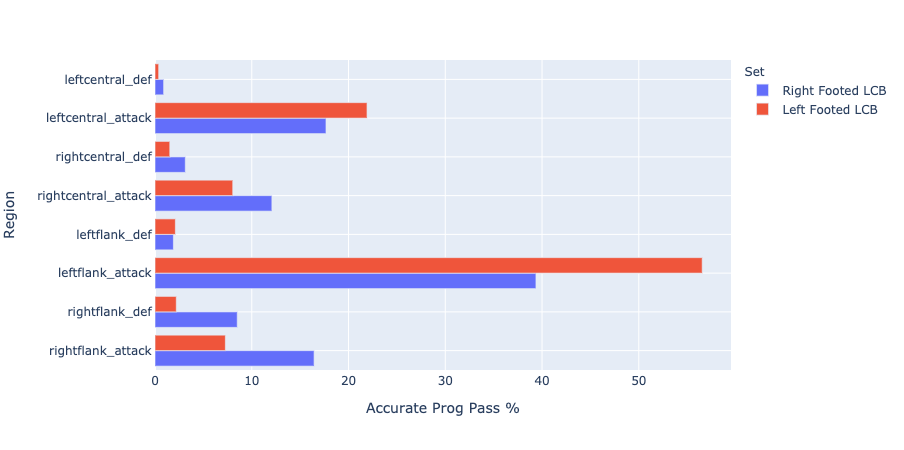

In [120]:
# data_reg = [['Right Flank Attack', 7.2727272727272725, 'RRRL'],
#             ['Right Flank Attack',10.58601134215501, 'RRLL'],
#             ['Right Flank Def', 10.875045012603529, 'RRRL'],
#             ['Right Flank Def', 6.301197227473219, 'RRLL'],
#             ['Left Flank Attack', 37.27043572200216, 'RRRL'],
#             ['Left Flank Attack', 43.28922495274102, 'RRLL'],
#             ['Left Flank Def', 3.456967951026287, 'RRRL'],
#             ['Left Flank Def', 2.898550724637681, 'RRLL'],
#             ['Right Central Attack', 12.171407994238386, 'RRRL'],
#             ['Right Central Attack', 12.917454316320102, 'RRLL'],
#             ['Right Central Def', 6.1937342455887645, 'RRRL'],
#             ['Right Central Def', 5.16698172652804, 'RRLL'],
#             ['Left Central Attack', 13.215700396110911, 'RRRL'],
#             ['Left Central Attack', 18.021424070573406, 'RRLL'],
#             ['Left Central Def', 0.4681310767014764, 'RRRL'],
#             ['Left Central Def', 0.8191556395715185, 'RRLL']]
lcb_lf_reg = list(zip(regions,lcb_lf_region_per))
lcb_lf_data_reg = [list(i) + ["Left Footed LCB"] for i in lcb_lf_reg]
lcb_rf_data = list(zip(regions,lcb_rf_region_per))
lcb_rf_data_reg = [list(i) + ["Right Footed LCB"] for i in lcb_rf_data]
data_reg = lcb_rf_data_reg + lcb_lf_data_reg
reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Prog Pass %', 'Set'])
fig = px.bar(reg, x="Accurate Prog Pass %", y="Region", color='Set', barmode='group', orientation='h')
fig.show()

**Performing Hypothesis Testing for percentage of passes made by LCBs in Right Flank, Left Flank and Central Region**

## Right - Flank

**Null Hypothesis:** The proportion of progressive passes made at the right flank by left footed LCB (left center back) should be greater than or equal to right footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made at the right flank by left footed LCB (left center back) should be less than right footed LCB (left center back) in a lineup with four defenders

**H0: P2 >= P1** <br>
**H1: P2 < P1** <br>
*P1 - RRRL, P2 - RRLL*

**The hypothesis stated signifies that we are performing a right tailed test**

In [33]:
# Right Flank HT

from statsmodels.stats.proportion import proportions_ztest
count = np.array([rrrl_region[0] + rrrl_region[1], rrll_region[0] + rrll_region[1]])
nobs = np.array([len(rrrl_prog_end_x),len(rrll_prog_end_x)] )
stat, pval = proportions_ztest(count, nobs, alternative ='larger')
print(stat, pval)

7.751137837747425 4.553638117057258e-15


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Left - Flank

**Null Hypothesis:** The proportion of progressive passes made at the left flank by right footed LCB (left center back) should be greater than or equal to left footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made at the left flank by right footed LCB (left center back) should be lesser than left footed LCB (left center back) in a lineup with four defenders

**H0: P1 >= P2** <br>
**H1: P1 < P2** <br>
*P1 - RRRL, P2 - RRLL*

**The hypothesis stated signifies that we are performing a left tailed test**

In [34]:
# Left Flank HT
from statsmodels.stats.proportion import proportions_ztest
count = np.array([rrrl_region[2] + rrrl_region[3], rrll_region[2] + rrll_region[3]])
nobs = np.array([len(rrrl_prog_end_x),len(rrll_prog_end_x) ])
stat, pval = proportions_ztest(count, nobs, alternative ='smaller')
print(stat, pval)

-3.5079068075166377 0.00022582361724489777


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Central - Region

**Null Hypothesis:** The proportion of progressive passes made in the central region by right footed LCB (left center back) should be equal to that of left footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of progressive passes made in the central region by right footed LCB (left center back) should not be equal to that of left footed LCB (left center back) in a lineup with four defenders

**H0: P1 = P2** <br>
**H1: P1 != P2** <br>
*P1 - RRRL, P2 - RRLL*

In [35]:
# Central Region HT
count = np.array([rrrl_region[4] + rrrl_region[5] + rrrl_region[6] + rrrl_region[7], rrll_region[4] + rrll_region[5] + rrll_region[6] + rrll_region[7]])
nobs = np.array([len(rrrl_prog_end_x), len(rrll_prog_end_x)])
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-3.275249902536123 0.0010556854216429708


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.